### Imports

In [33]:
import tensorflow as tf
from Music_utils import *

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write

from tensorflow.keras import Sequential , layers

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

In [34]:
# Download the dataset
songs = load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[1]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!


In [35]:
play_song(example_song)

In [36]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


### Vector Embedding

In [37]:
# Create a mapping from character to unique index.
char2idx = {u:i for i, u in enumerate(vocab)}

In [38]:
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [39]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [40]:
### Vectorize the songs string ###

def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

vectorized_songs = vectorize_string(songs_joined)

In [41]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [42]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]

  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]


  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


In [43]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 56 ('a')
  expected output: 65 ('j')
Step   1
  input: 65 ('j')
  expected output: 70 ('o')
Step   2
  input: 70 ('o')
  expected output: 73 ('r')
Step   3
  input: 73 ('r')
  expected output: 0 ('\n')
Step   4
  input: 0 ('\n')
  expected output: 30 ('E')


### LSTM Model

In [44]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [45]:
### Defining the RNN Model ###

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors
    #   of a fixed embedding size
    layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units.
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size.
    layers.Dense(vocab_size)
  ])

  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (32, None, 256)           21248     
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


### Sample_prediction(Un-Trained)

In [47]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [48]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([36, 51, 54, 74, 30, 79, 75, 19, 36, 30, 11,  1, 69, 15, 21, 59, 14,
        6, 27, 37,  3, 63, 62, 13, 65, 52, 73, 26, 81, 12, 12, 19, 50,  8,
       29,  2, 35, 35, 25, 69, 29,  8, 53, 31, 80, 73, 56, 70, 27,  2, 66,
       65, 28, 72, 56, 40, 40, 20, 44, 71, 33, 35, 17,  9, 44, 56, 65, 25,
       25,  1, 34, 60, 60, 71, 57, 41, 21, 20, 47,  5, 12, 72,  7, 69, 13,
        7, 35, 60, 35, 16, 58, 80,  2, 12, 18,  4, 52, 52, 61, 81],
      dtype=int64)

In [49]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 ' eAA2:|!\neAcA eAcA|d^cdB GABd|eAcA cdef|gedB eAAg|!\neAcA eAcA|d^cdB GABd|cAdB cdef|gedB eAA2:|!\nae^c'

Next Char Predictions: 
 'KZ^sExt7KE/ n39d2(BL"hg1j[rAz007Y,D!JJ>nD,]FyraoB!kjCqaOO8SpHJ5-Saj>> IeepbP98V\'0q)n1)JeJ4cy!06#[[fz'


### Loss Function

In [50]:
### Defining the loss function ###

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss


example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.41893


In [51]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

### Model Training

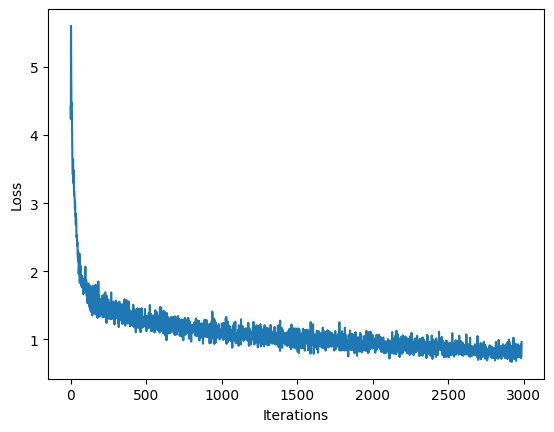

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:01<00:00, 16.50it/s]


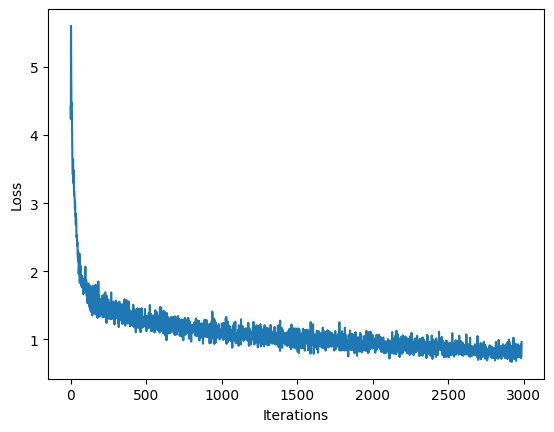

In [53]:
### Define optimizer and training operation ###


model = build_model(vocab_size, params["embedding_dim"], params["rnn_units"], params["batch_size"])


optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    y_hat = model(x) 
    

    
    loss = compute_loss(y, y_hat) 
    

  # Now, compute the gradients
  grads = tape.gradient(loss, model.trainable_variables)
  

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
#experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  # log the loss to the Comet interface! we will be able to track it there.

  # Update the progress bar and also visualize within notebook
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
#experiment.flush()


### Restore last Checkpoint

In [54]:
model = build_model(vocab_size, params["embedding_dim"], params["rnn_units"], batch_size=1) # TODO

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_5 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [55]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  
  input_eval = [char2idx[s] for s in start_string] # TODO
 
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      
      predictions = model(input_eval)


      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO
      # text_generated.append('''TODO''')

  return (start_string + ''.join(text_generated))

In [56]:
generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.18it/s]


In [58]:
### Play back generated songs ###

generated_songs = extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

Found 0 songs in text
